In [1]:
# general imports
import numpy as np
import sys
sys.path.append("..")

# import custom gridworld library files
from dictionary_gridworld_library import gridworld_simulator
from dictionary_gridworld_library import gridworld_visualizers
from dictionary_gridworld_library import gridworld_qlearn
from dictionary_gridworld_library import history_plotter

# these lines allow you to change backend files without
# needing to restart your kernel in order to see any 
# changes you made applied in the notebook
%load_ext autoreload
%autoreload 2

#### <span style="color:#a50e3e;">Exercise 3: </span>  Shortest path via Q-Learning (using gridworld)

In this exercise we give you a gridworld simulator, like the one shown in the notes ([here](https://jermwatt.github.io/mlrefined/blog_posts/18_Reinforcement_Learning_Foundations/18_2_Q_learning.html) and [here](https://jermwatt.github.io/mlrefined/blog_posts/18_Reinforcement_Learning_Foundations/18_3_Q_learning_enhancements.html)), and ask you to implement a complete version of the standard Q-Learning algorithm - i.e., including a explotation / exploration and long-short term trade-off parameters - in order to solve the gridworld shortest path environment.  In addition here instead of using an array to represent the $Q$ function you will use a [Python dictionary](https://www.tutorialspoint.com/python/python_dictionary.htm), a more appropriate choice given the nature of gridworld. 

To complete and test your implementation you will need the following backend files - loaded in via the first cell in this notebook

- **gridworld_simulator.py** - defines the gridworld $f_{\text{system}}$ - that is a graphical model of the environment, as well as a reward structure 


- **gridworld_visualizers.py** - defines various visualizations for each gridworld, including a plain plot of the environment and one with arrows painted on top of each square to denote the optimal action there defined by $Q$, and a simple plotting tool to plot total reward history per episode of training

To define a gridworld testing environment we can use the **gridworld_simulator.py** function as shown below for creating a *small maze* - an instance of this gridworld is assigned to the `simulator` variable.  You can look inside of this file to see how to create additional testing environments (e.g., you can see another world by replacing `world_type = maze` with `world_type = moat`).  Here standard (low penalty) squares are colored in light gray, hazard squares (high penalty) are colored red, and the goal state is colored in green.  An example agent location is colored in blue.

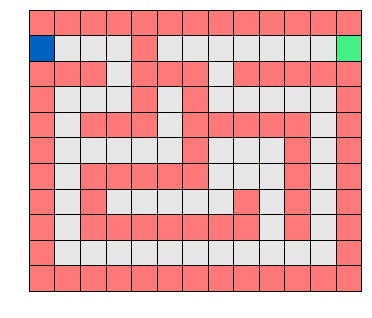

In [42]:
# generate instance of gridworld
simulator = gridworld_simulator.Simulator(world_size = 'small', world_type = 'maze')

# visualize the gridworld
plotter = gridworld_visualizers.Visualizer(simulator)
plotter.show_gridworld()

The `simulator` variable now contains a complete instance of this gridworld, including its graphical structure, $f_{\text{system}}$, rewards, allowable actions, etc.,  For example, we can list all of the states of this gridworld via the `simulator` as shown below.  Notice these are *tuples* ranging from $(0,0)$, the state / square located in the bottom left corner of the world, to $(10,12)$ in the top right corner.  This differs from how the gridworld states are encoded in the notes - there they are indexed using a single number.  We also print out the preset maximum allowable steps per episode.

In [3]:
# print out the first few and last states of this gridworld
print ('the first 5 states of this gridworld are')
print (simulator.states[:5])
print ('and the last 5 states are')
print (simulator.states[-5:])
print ('the maximum steps allowed per episode is set at')
print (simulator.max_steps)

the first 5 states of this gridworld are
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
and the last 5 states are
[(10, 8), (10, 9), (10, 10), (10, 11), (10, 12)]
the maximum steps allowed per episode is set at
286


We can likewise print out all allowable actions as shown below.  Here these are - at each state - to move left, right, up, or down one square.  Notice that these are naturally stored in a dictionary, whose keys are the actions *in English* and corresponding values their numerical translation.

In [4]:
# print out allowable actions
simulator.action_choices

{'down': [-1, 0], 'left': [0, -1], 'right': [0, 1], 'up': [1, 0]}

You can also see the reward setting for each state type as shown below.

In [5]:
# print out the current setting of reward structure for gridworld
print ('reward for standard state is preset = ' + str(simulator.standard_reward))
print ('reward for hazard state is preset = ' + str(simulator.hazard_reward))
print ('reward for goal state is preset = ' + str(simulator.goal_reward))

reward for standard state is preset = -0.001
reward for hazard state is preset = -10.0
reward for goal state is preset = 0


Now, we have updated the syntax for using this `simulator` (versus what is seen in the notes) so that its usage syntax better alligns with that used in the popular [Openai Gym](https://gym.openai.com/) - which you will be using in the exercises following this one.  That is to move our agent from one state to the next we use the `step` command (which includes our $f_{\text{system}}$) that - just as we have seen previously - tells us how to transition from one state to the next given a particular action.  An example of this is shown in the next Python cell.


Here we choose a random initial location via the `reset` command, and choose the action 'right'.  Feeding this action into `simulator.step` gives three returns

```
next_state, reward, done = simulator.step(action)
```

These returns include

- `next_state` - the next state we transition to given our chosen action

- `reward` - the reward we received for making this transition

- `done` - a `True/False` variable telling us if our agent has reached the goal or whether we have ran out of iterations (in the current episode) in which case `done = True`, otherwise `done = False`

In [6]:
# reset - randomly choose starting location for agent
state = simulator.reset()

# pick an action
action = 'right'

# transition from one state to another the 'step' function 
# which includes in it our f_system
next_state, reward, done = simulator.step(action)

# print out everything
print ('our original state was ' + str(state))
print ('we took action = ' + action)
print ('this led us to state = ' + str(next_state))
print ('which gives a reward = ' + str(reward))
print ('did this lead to this episode end?, well done = ' + str(done))

our original state was (3, 2)
we took action = right
this led us to state = (3, 3)
which gives a reward = -0.001
did this lead to this episode end?, well done = False


Instead of using an array to represent $Q$ we now need to use a dictionary (this is a more appropriate choice anyway given the context of the problem).  In particular, you need to use the following implementation of $Q$ as your initialization.  This is a dictionary that contains an initialization of $0$ for every state-action pair.

In [7]:
# initialize Q as a dictionary of all zeros
Q = {}
for state in simulator.states:
    Q[state] = {}
    Q[state]['down'] = 0.0
    Q[state]['up'] = 0.0
    Q[state]['left'] = 0.0
    Q[state]['right'] = 0.0

You can use the Python function `draw_arrow_map` included in the `gridworld_visualizers` backend file to visualize the optimal control law at each state based on a $Q$ function of this form - as shown below.  Having been initialized to be all zeros the optimal action to take in each instance defaults to a single action uniformly.

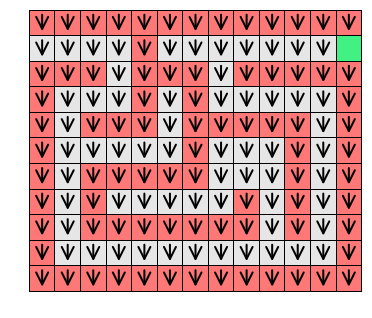

In [8]:
# Visualize the control law defined by an initialization of Q
plotter.draw_arrow_map(Q)

If $Q$ is initialized randomly, which is also fine, the resulting optimal control law map will look as shown below.

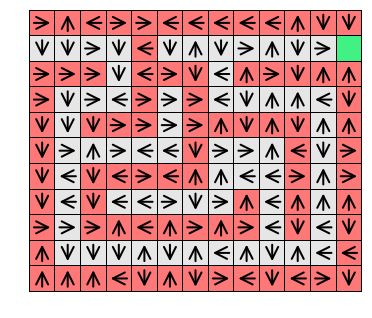

In [12]:
# initialize Q as a dictionary of all zeros
Q = {}
for state in simulator.states:
    Q[state] = {}
    Q[state]['down'] = np.random.randn(1)
    Q[state]['up'] = np.random.randn(1)
    Q[state]['left'] = np.random.randn(1)
    Q[state]['right'] = np.random.randn(1)
    
# Visualize the control law defined by an initialization of Q
plotter.draw_arrow_map(Q)

Once trained, however, $Q$ should provide a perfect set of optimal actions to take for every square in gridworld.  Shown below is the optimal control law provided by a properly trained $Q$ of this form, one which you will reproduce via your implementation.

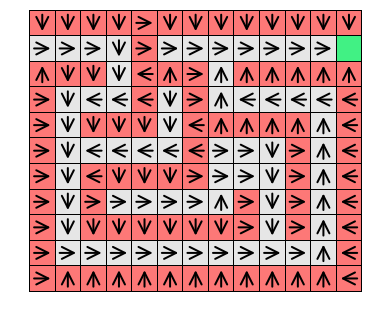

In [97]:
# Using a fully trained Q
plotter.draw_arrow_map(Q)

Using the implementation shown in the notes as a template, fashion a new implementation of Q-Learning for gridworld using the dictionary form of $Q$ shown above, as well as the various utilities whose use is demonstrated above.  Your implementation should include both an exploitation / exploration parameter, as well as a short-term / long-term trade-off parameter.  

In particular, note a few technical points about your final implementation:

- Here - as is convention when discussing Q-Learning - we are using a *maximization* mentality (hence the 'reward' returned by $f_{\text{system}}$ above).  That is our Q-Learning step is written as

\begin{equation}
Q\left(s_t,a_t\right) = r_t + \underset{a_{t+1}}{\text{maximize}}\,\,Q\left(s_{t+1},a_{t+1}\right)
\end{equation}


- To achieve the optimal control law shown above we ran Q-Learning for 300 episodes, with exploration / exploitation parameter set to $p = 0.2$ for all steps / episodes, and the short-term/long-term tradeoff set to $1$.  Storing each episode's total reward in a list called `episode_rewards` when plotted they looked as follows:

### My Implementation

In [43]:
# initialize Q as a dictionary of all zeros
Q = {}
for state in simulator.states:
    Q[state] = {}
    Q[state]['down'] = 0.0
    Q[state]['up'] = 0.0
    Q[state]['left'] = 0.0
    Q[state]['right'] = 0.0

In [44]:
episodes = 300
p = 0.2
tradeoff = 1
simulator.max_steps = 286 #default value
import random
random.seed(a=123)
episode_rewards = np.zeros((episodes,1))
for e in range(episodes):
    state = simulator.reset()
    sum_reward = 0
    done=False
    while done==False:
        r = np.random.uniform()
        if r<=p:
            action = random.choice(list(Q[state].keys()))
        else:
            action = max(Q[state],key=Q[state].get)
        next_state, reward, done = simulator.step(action)
        if done==False:
            Q[state][action] = reward+tradeoff*max(Q[next_state].values())
        else:
            Q[state][action] = reward
        state = next_state
        sum_reward = sum_reward+reward
    episode_rewards[e] = sum_reward

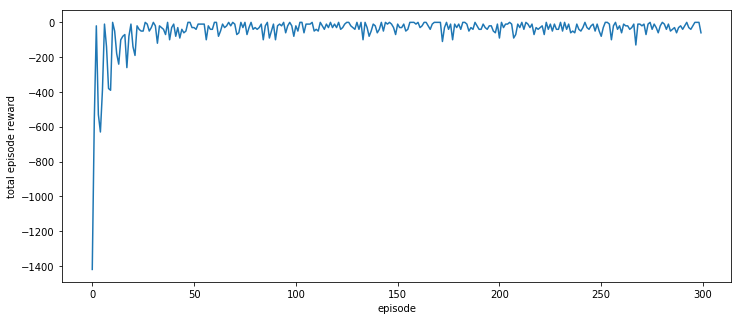

In [45]:
# plot the total episode rewards from a run of Q-Learning
plotter.plot_reward_history(episode_rewards)

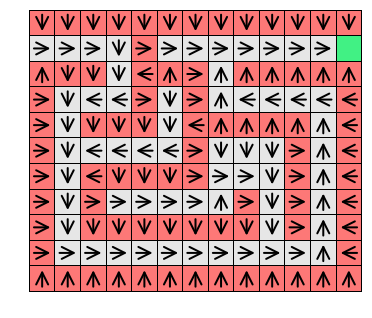

In [46]:
# Using a fully trained Q
plotter.draw_arrow_map(Q)

## Large Gridworld

With your implementation you should then be able to solve any of other gridworld levels callable via `gridworld_simulator`.  For example, below we load in the *large maze* world, run the same Q-Learning algorithm for 1000 episodes (again with same parameters as above), and show both the total reward per episode plot and the final control law.  Notice here: our learned optimal control law is good, but *not* perfect.  If we trained longer, and/or adjusted our exploration / exploitation parameter more delicately we could achieve a perfect control law.

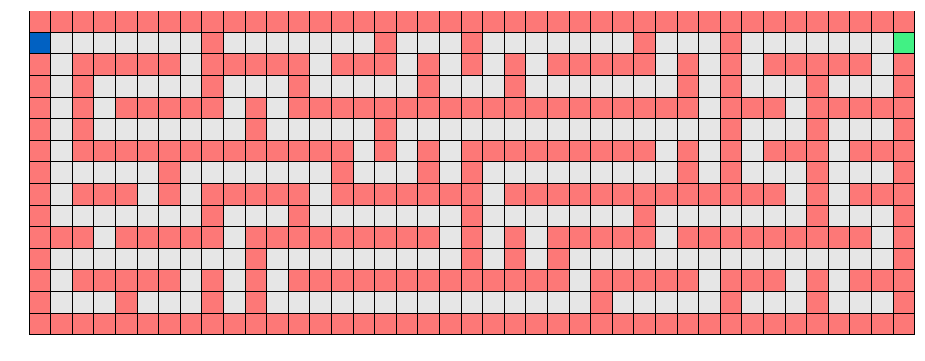

In [47]:
# generate instance of gridworld
simulator = gridworld_simulator.Simulator(world_size = 'large', world_type = 'maze')

# show the world
animator = gridworld_visualizers.Visualizer(simulator)
animator.show_gridworld()

### My Implementation - Large Gridworld

In [48]:
# initialize Q as a dictionary of all zeros
Q = {}
for state in simulator.states:
    Q[state] = {}
    Q[state]['down'] = 0.0
    Q[state]['up'] = 0.0
    Q[state]['left'] = 0.0
    Q[state]['right'] = 0.0

In [49]:
episodes = 1000
p = 0.2
tradeoff = 1
simulator.max_steps = 286 #default value
import random
random.seed(a=123)
episode_rewards = np.zeros((episodes,1))
for e in range(episodes):
    state = simulator.reset()
    sum_reward = 0
    done=False
    while done==False:
        r = np.random.uniform()
        if r<=p:
            action = random.choice(list(Q[state].keys()))
        else:
            action = max(Q[state],key=Q[state].get)
        next_state, reward, done = simulator.step(action)
        if done==False:
            Q[state][action] = reward+tradeoff*max(Q[next_state].values())
        else:
            Q[state][action] = reward
        state = next_state
        sum_reward = sum_reward+reward
    episode_rewards[e] = sum_reward

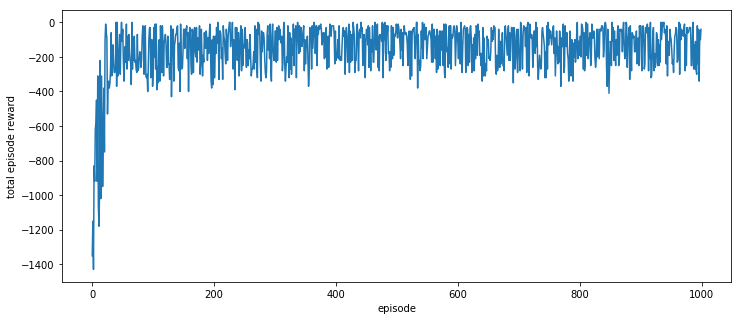

In [50]:
# plot the total episode rewards from a run of Q-Learning
plotter.plot_reward_history(episode_rewards)

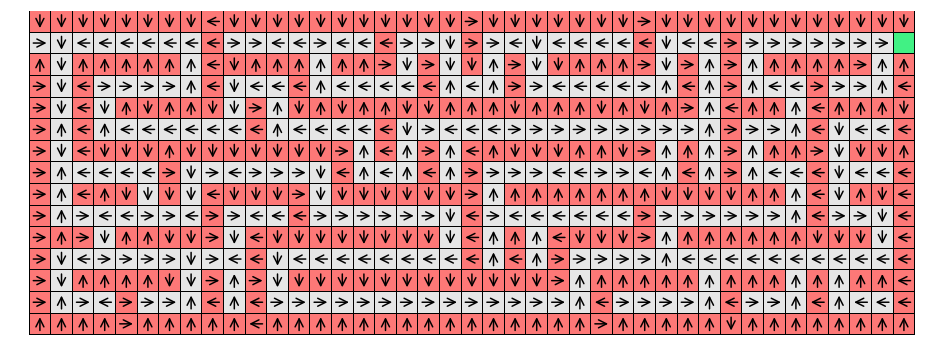

In [51]:
# Using a fully trained Q
animator.draw_arrow_map(Q)